# Import Libraries

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from scipy.stats import mode

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import log_loss
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

import gc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [328]:
df = pd.read_csv('/kaggle/input/dstcdata/Bảng ĐH_Vòng 2_DSTC 2024_Dataset/01_dataset.csv')


In [329]:
df.head()

,customer_id,label,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,SHORT_TERM_COUNT_BANK,MID_TERM_COUNT_BANK,LONG_TERM_COUNT_BANK,SHORT_TERM_COUNT_NON_BANK,MID_TERM_COUNT_NON_BANK,...,ENQUIRIES_FROM_BANK_6M_9M,ENQUIRIES_FROM_BANK_9M_12M,ENQUIRIES_FROM_BANK_6M_12M,ENQUIRIES_FROM_BANK_3M_12M,ENQUIRIES_FROM_NON_BANK_3M_6M,ENQUIRIES_FROM_NON_BANK_6M_9M,ENQUIRIES_FROM_NON_BANK_9M_12M,ENQUIRIES_FROM_NON_BANK_6M_12M,ENQUIRIES_FROM_NON_BANK_3M_12M,OUTSTANDING_BAL_ALL_CURRENT
0,1639,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,2.000000,2.000000,2.000000,7.000000,3.666667,7.0,3.666667,3.666667,1000000.0
1,23717,0,10.0,1.0,NaN,7.0,1.0,1.0,4.0,NaN,...,2.000000,7.000000,2.000000,2.000000,7.000000,7.000000,7.0,7.000000,7.000000,NaN
2,19474,0,7.0,7.0,NaN,7.0,NaN,1.0,1.0,4.0,...,7.000000,5.571429,5.571429,5.571429,7.000000,7.000000,7.0,7.000000,7.000000,1000620.0
3,15505,0,7.0,1.0,1.0,NaN,1.0,NaN,7.0,1.0,...,6.090909,7.000000,NaN,NaN,4.500000,5.333333,7.0,5.333333,3.666667,1000170.0
4,1538,1,NaN,NaN,1.0,1.0,1.0,1.0,1.0,4.0,...,2.000000,2.000000,2.000000,2.000000,3.666667,7.000000,7.0,7.000000,3.666667,1000270.0


In [330]:
len(df)


20000

In [331]:
filtered_df = df[(df["NUMBER_OF_RELATIONSHIP"] >= 7) &
                 (df["NUMBER_OF_LOANS"] >= 4) &
                 (df["NUM_NEW_LOAN_TAKEN_3M"] >= 4)]
len(filtered_df[filtered_df["label"]==1])/len(filtered_df)

0.10499052432090966

In [332]:
filtered_df = df[(df["NUMBER_OF_RELATIONSHIP"] < 7) &
                 (df["NUMBER_OF_LOANS"] < 4) &
                 (df["NUM_NEW_LOAN_TAKEN_3M"] < 4)]
len(filtered_df[filtered_df["label"]==1])/len(filtered_df)

1.0

# Initial Processing

### Missing Values

In [333]:
df.isnull().sum(axis = 0)

customer_id                          0
label                                0
SHORT_TERM_COUNT                  2000
MID_TERM_COUNT                    2000
LONG_TERM_COUNT                   2000
                                  ... 
ENQUIRIES_FROM_NON_BANK_6M_9M     2000
ENQUIRIES_FROM_NON_BANK_9M_12M    2000
ENQUIRIES_FROM_NON_BANK_6M_12M    2000
ENQUIRIES_FROM_NON_BANK_3M_12M    2000
OUTSTANDING_BAL_ALL_CURRENT       2000
Length: 124, dtype: int64

### Label Distribution

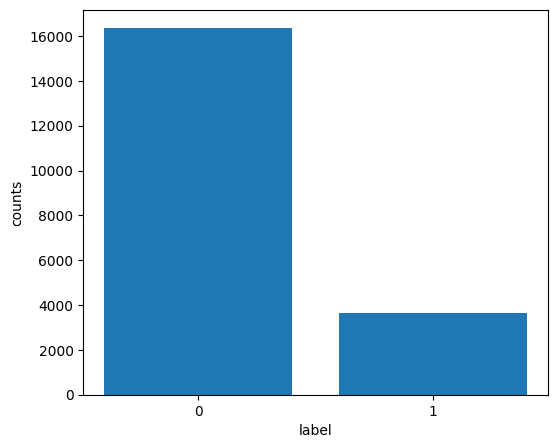

In [334]:
fig = plt.figure(figsize=(6,5))
plt.bar(df.label.value_counts().index, df.label.value_counts().values)
plt.xlabel('label')
plt.ylabel('counts')
plt.xticks([0,1])
plt.show()

## Fill missing values with mean

In [335]:
numerical_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns


for col in df.select_dtypes('object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in df.select_dtypes('number').columns:
    df[col].fillna(df[col].mean(), inplace=True)


In [336]:
df.shape

(20000, 124)

# ROC curve

In [337]:
results = []
from sklearn.metrics import roc_curve, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def evaluate(y_test,y_pred,y_pred_proba, model):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    # Plot the ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.fill_between(fpr, 0, tpr, color='skyblue', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
    # Add labels and title
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve for {}'.format(model))

    # Generate classification report
    report = classification_report(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, output_dict=True)
    f1_score = classification_report_str['weighted avg']['f1-score']
    auc_score = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc_score - 1

    

    # Print accuracy and classification report
    print("\nClassification Report:\n", report)
    print("\nGini Index: {:.2f}", gini)

    # Add result
    results.append({"Model": model,"GINI": gini, "ROC AUC Score": auc_score})
    # Show the plot
    plt.show()

# Baseline Models Performances

## Baseline Model - Logistic Regression

In [338]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your data is stored in X and y
X_train, X_val_test, y_train, y_val_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.4, random_state=42)
# Split the validation and test sets into equal proportions
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
X_train.drop('customer_id', axis=1, inplace=True)
X_val.drop('customer_id', axis=1, inplace=True)
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 12000
Validation set size: 4000
Test set size: 4000


Accuracy: 82.25%
AUC Score: 0.6502594289139089

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      3290
           1       0.00      0.00      0.00       710

    accuracy                           0.82      4000
   macro avg       0.41      0.50      0.45      4000
weighted avg       0.68      0.82      0.74      4000


Gini Index: {:.2f} 0.30051885782781773


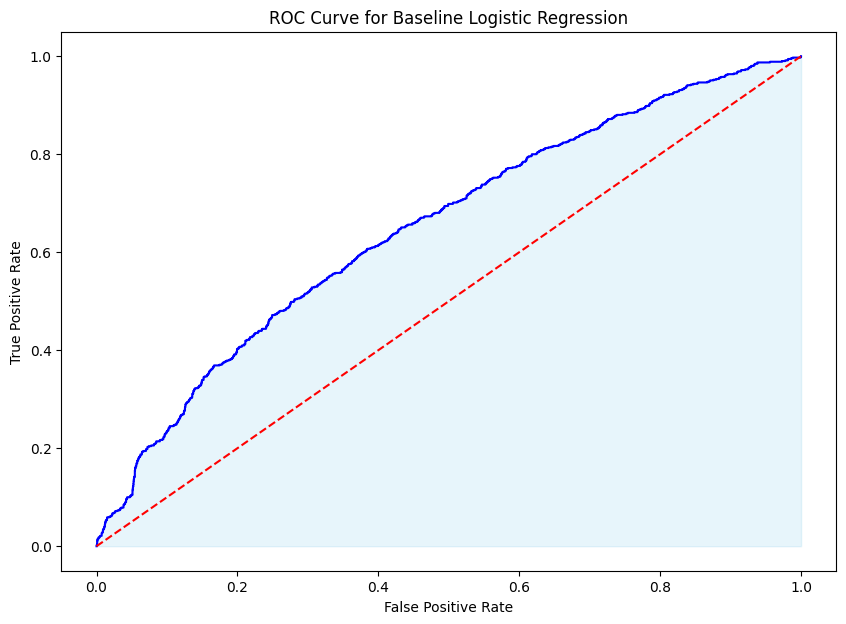

In [339]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model with 'sag' solver
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")
evaluate(y_val,y_pred,y_pred_proba, "Baseline Logistic Regression")

## Baseline Model - LightGBM

[LightGBM] [Info] Number of positive: 1773, number of negative: 7827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9824
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184688 -> initscore=-1.484906
[LightGBM] [Info] Start training from score -1.484906
[LightGBM] [Info] Number of positive: 1773, number of negative: 7827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9827
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184688 -> initscore=-1.484906
[LightGBM] [Info] Start training from score -1.484906
[LightGBM] [Info

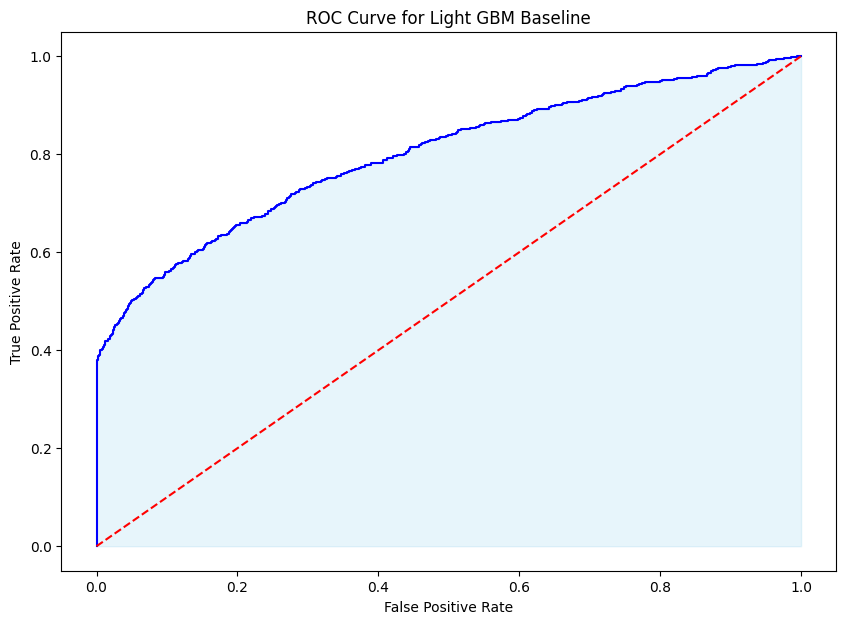

In [340]:
lgb_model = lgb.LGBMClassifier()

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
lgb_model.fit(X_train, y_train)

# Predictions on the test set
lgb_y_pred = lgb_model.predict(X_val)
y_pred_proba = lgb_model.predict_proba(X_val)[:, 1]
# Calculate accuracy and AUC Score on the test set
lgb_accuracy = accuracy_score(y_val, lgb_y_pred)
lgb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {lgb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {lgb_auc_score}")


accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")
evaluate(y_val,lgb_y_pred,y_pred_proba, "Light GBM Baseline")

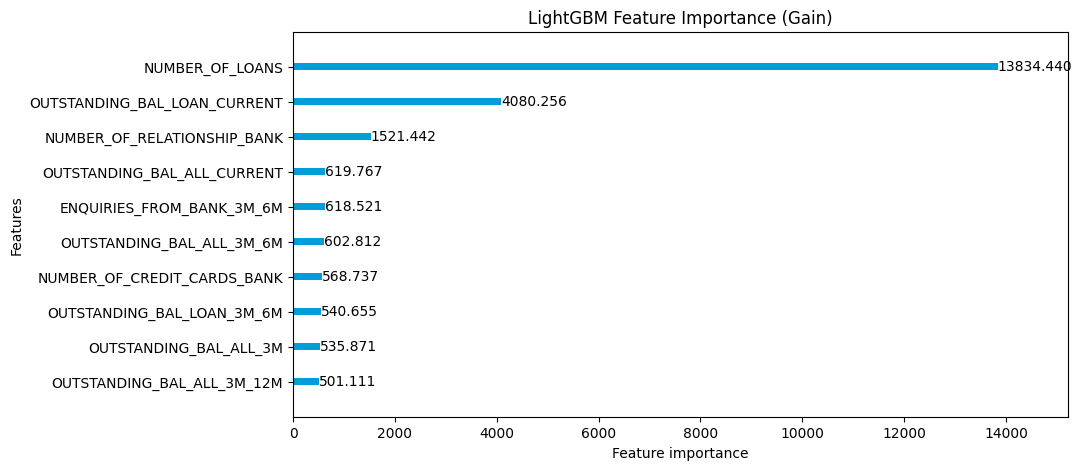

In [341]:
lgb.plot_importance(lgb_model, importance_type="gain", max_num_features=10, figsize=(10,5), title="LightGBM Feature Importance (Gain)", grid=False, color = "#009dd9")
plt.show()


# Feature Engineering

### Drop Features that has too many duplicate values

In [342]:
df.drop(["CREDIT_CARD_MONTH_SINCE_10DPD","CREDIT_CARD_MONTH_SINCE_30DPD","CREDIT_CARD_MONTH_SINCE_60DPD","CREDIT_CARD_MONTH_SINCE_90DPD"], inplace = True, axis = 1)

### Feature 1: Binary Features (Short Term, Mid Term, Long Term)

In [343]:
df_t = df[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', 'label']].copy(deep=True)
df_t['MANY_SHORT'] = np.where(df_t['SHORT_TERM_COUNT'] >= 4, 1, 0)
df_t['MANY_MID'] = np.where(df_t['MID_TERM_COUNT'] >= 4, 1, 0)
df_t['MANY_LONG'] = np.where(df_t['LONG_TERM_COUNT'] >= 4, 1, 0)
df_t['Theory 1'] = (df_t['MANY_SHORT'] * 10 + df_t['MANY_MID'] * 5 + df_t['MANY_LONG']) / 15
df['Diff_in_term_count'] = df_t['Theory 1']

### Feature 2: Binary Features (Number of Loans, Number of Loans Bank, Number of Loans Non Bank) 

In [344]:
df_t = df[['NUMBER_OF_LOANS', 'NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK', 'label']].copy(deep=True)
df_t['MANY_LOANS'] = np.where(df_t['NUMBER_OF_LOANS'] >= 4, 1, 0)
df_t['MANY_LOANS_BANK'] = np.where(df_t['NUMBER_OF_LOANS_BANK'] >= 4, 1, 0)
df_t['MANY_LOANS_NON_BANK'] = np.where(df_t['NUMBER_OF_LOANS_NON_BANK'] >= 4, 1, 0)
df_t['Theory 1'] = df_t.iloc[:, -3:].sum(axis=1)
df['Diff_in_num_loan'] = df_t['Theory 1']

### Feature 3: Differece in 3 features realted to Number of Relationships

In [345]:
df_t = df[['NUMBER_OF_RELATIONSHIP', 'NUMBER_OF_RELATIONSHIP_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK', 'label']].copy(deep=True)
# df_t.median()
df_t['MANY_RELATIONSHIP'] = np.where(df_t['NUMBER_OF_RELATIONSHIP'] >= 4, 1, 0)
df_t['MANY_RELATIONSHIP_BANK'] = np.where(df_t['NUMBER_OF_RELATIONSHIP_BANK'] >= 4, 1, 0)
df_t['MANY_RELATIONSHIP_NON_BANK'] = np.where(df_t['NUMBER_OF_RELATIONSHIP_NON_BANK'] >= 4, 1, 0)

df_t['Theory 1'] = (df_t['MANY_RELATIONSHIP'] * 5 + df_t['MANY_RELATIONSHIP_BANK'] + df_t['MANY_RELATIONSHIP_NON_BANK']) / 7
df['Diff_in_num_relationship'] = df_t['Theory 1']

### Feature 4

In [346]:
cols = ['NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M',
       'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M',
       'NUM_NEW_LOAN_TAKEN_BANK_3M', 'NUM_NEW_LOAN_TAKEN_BANK_6M',
       'NUM_NEW_LOAN_TAKEN_BANK_9M', 'NUM_NEW_LOAN_TAKEN_BANK_12M',
       'NUM_NEW_LOAN_TAKEN_NON_BANK_3M', 'NUM_NEW_LOAN_TAKEN_NON_BANK_6M',
       'NUM_NEW_LOAN_TAKEN_NON_BANK_9M', 'NUM_NEW_LOAN_TAKEN_NON_BANK_12M', 'label']
# cols = ['NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M',
#        'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M', 'label']
df_t = df[cols].copy(deep=True)
df_t['MANY_NEW_LOAN_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_12M'] >= 4, 1, 0)

df_t['MANY_NEW_LOAN_BANK_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_BANK_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_BANK_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_BANK_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_12M'] >= 4, 1, 0)

df_t['MANY_NEW_LOAN_NON_BANK_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_12M'] >= 4, 1, 0)

df_t['Theory 1'] = df_t.iloc[:, -12:].sum(axis=1)
df['Diff_in_num_new_loan'] = df_t['Theory 1']

## Feature 5: Ratio with number of loans

In [347]:
cols = ['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', "SHORT_TERM_COUNT_BANK","MID_TERM_COUNT_BANK","LONG_TERM_COUNT_BANK","SHORT_TERM_COUNT_NON_BANK",
        "MID_TERM_COUNT_NON_BANK","LONG_TERM_COUNT_NON_BANK","NUMBER_OF_LOANS_BANK","NUMBER_OF_LOANS_NON_BANK", "NUMBER_OF_RELATIONSHIP","NUMBER_OF_RELATIONSHIP_BANK","NUMBER_OF_RELATIONSHIP_NON_BANK",
        'NUMBER_OF_LOANS', 'label']
df_t = df[cols].copy(deep=True)
# df_t['NUMBER_OF_LOANS'].fillna(df_t['NUMBER_OF_LOANS'].mean(), inplace=True)
df[['RATIO_SHORT', 'RATIO_MID', 'RATIO_LONG']] = \
df_t[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']].div(df_t['NUMBER_OF_LOANS'], axis=0)
df[['RATIO_SHORT_BANK', 'RATIO_MID_BANK', 'RATIO_LONG_BANK']] = \
df_t[['SHORT_TERM_COUNT_BANK', 'MID_TERM_COUNT_BANK', 'LONG_TERM_COUNT_BANK']].div(df_t['NUMBER_OF_LOANS_BANK'], axis=0)
df[['RATIO_SHORT_NON_BANK', 'RATIO_MID_NON_BANK', 'RATIO_LONG_NON_BANK']] = \
df_t[['SHORT_TERM_COUNT_NON_BANK', 'MID_TERM_COUNT_NON_BANK', 'LONG_TERM_COUNT_NON_BANK']].div(df_t['NUMBER_OF_LOANS_NON_BANK'], axis=0)
df[['RATIO_RELATIONSHIP']] = df_t[['NUMBER_OF_RELATIONSHIP']].div(df_t['NUMBER_OF_LOANS'], axis=0)
df[['RATIO_RELATIONSHIP_BANK']] = df_t[['NUMBER_OF_RELATIONSHIP_BANK']].div(df_t['NUMBER_OF_LOANS_BANK'], axis=0)
df[['RATIO_RELATIONSHIP_NON_BANK']] = df_t[['NUMBER_OF_RELATIONSHIP_NON_BANK']].div(df_t['NUMBER_OF_LOANS_NON_BANK'], axis=0)


## Transform OUTSTANDING BALANCE into 10 bins

In [348]:
df_temp = df.copy(deep=True)
corr_matrix = df_temp.corr()
filtered_corr = df_temp.corr().applymap(lambda x: x if abs(x) > 0.5 and x != 1 else np.nan)

upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = filtered_corr.where(upper_tri).stack()

# Step 3: Drop one column for each pair of highly correlated features
to_drop = set()
for col1, col2 in high_corr_pairs.index:
    if col1 not in to_drop and col2 not in to_drop:
        to_drop.add(col2)  # Keep col1, drop col2

# Step 4: Drop the identified columns
df = df_temp.drop(columns=to_drop)

print(f"Columns to drop: {to_drop}")
print(f"Reduced dataframe shape: {df.shape}")

Columns to drop: {'ENQUIRIES_FROM_BANK_6M_12M', 'RATIO_LONG', 'OUTSTANDING_BAL_ALL_3M_6M', 'NUM_NEW_LOAN_TAKEN_6M', 'OUTSTANDING_BAL_ALL_6M_9M', 'OUTSTANDING_BAL_CC_9M_12M', 'ENQUIRIES_9M', 'OUTSTANDING_BAL_CC_9M', 'ENQUIRIES_FROM_BANK_3M_6M', 'MID_TERM_COUNT_NON_BANK', 'OUTSTANDING_BAL_CC_CURRENT', 'ENQUIRIES_FOR_CC_9M', 'OUTSTANDING_BAL_CC_6M_12M', 'OUTSTANDING_BAL_CC_12M', 'ENQUIRIES_FROM_NON_BANK_3M', 'INCREASING_BAL_3M_CC', 'ENQUIRIES_FROM_BANK_FOR_CC_3M', 'LONG_TERM_COUNT_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK', 'NUM_NEW_LOAN_TAKEN_NON_BANK_6M', 'OUTSTANDING_BAL_ALL_9M', 'ENQUIRIES_FROM_BANK_FOR_CC_6M', 'OUTSTANDING_BAL_CC_6M', 'ENQUIRIES_FOR_LOAN_12M', 'OUTSTANDING_BAL_CC_3M_12M', 'ENQUIRIES_FROM_BANK_FOR_LOAN_12M', 'NUM_NEW_LOAN_TAKEN_BANK_3M', 'Diff_in_num_relationship', 'ENQUIRIES_FROM_BANK_9M', 'NUMBER_OF_RELATIONSHIP', 'NUM_NEW_LOAN_TAKEN_NON_BANK_3M', 'RATIO_LONG_NON_BANK', 'ENQUIRIES_6M', 'OUTSTANDING_BAL_ALL_12M', 'Diff_in_num_loan', 'OUTSTANDING_BAL_LOAN_9M_12M', 'OUTS

In [349]:
df

,customer_id,label,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,LONG_TERM_COUNT_NON_BANK,NUMBER_OF_LOANS_BANK,NUMBER_OF_LOANS_NON_BANK,NUMBER_OF_CREDIT_CARDS,NUMBER_OF_CREDIT_CARDS_NON_BANK,...,ENQUIRIES_9M_12M,ENQUIRIES_FROM_BANK_6M_9M,Diff_in_term_count,RATIO_SHORT,RATIO_SHORT_BANK,RATIO_SHORT_NON_BANK,RATIO_MID_NON_BANK,RATIO_RELATIONSHIP,RATIO_RELATIONSHIP_BANK,RATIO_RELATIONSHIP_NON_BANK
0,1639,1,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,...,7.000000,1.524688,0.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000
1,23717,0,10.000000,1.000000,1.063333,1.002333,7.0,4.000000,10.0,4.000000,...,7.000000,2.000000,0.666667,1.188307,1.000,1.000000,0.682708,2.257783,1.857143,1.750000
2,19474,0,7.000000,7.000000,1.063333,1.002333,10.0,4.000000,7.0,2.197833,...,5.888889,7.000000,1.000000,0.538462,0.700,0.250000,1.000000,1.461538,1.600000,1.000000
3,15505,0,7.000000,1.000000,1.000000,1.000000,1.0,7.000000,7.0,1.000000,...,7.000000,6.090909,0.666667,1.000000,3.177,1.000000,0.142857,1.857143,7.000000,0.969690
4,1538,1,6.040667,3.316833,1.000000,1.000000,1.0,5.589667,4.0,4.000000,...,7.000000,2.000000,0.666667,0.717817,1.000,0.178902,0.715606,0.831815,1.000000,1.252311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,13215,0,4.000000,1.000000,1.000000,1.000000,4.0,1.000000,1.0,1.000000,...,6.517224,-3.000000,0.666667,1.000000,1.000,1.000000,1.000000,1.000000,1.722750,1.000000
19996,938,0,4.000000,1.000000,1.000000,1.000000,1.0,4.000000,1.0,1.000000,...,7.000000,2.000000,0.666667,1.000000,1.000,0.962625,0.250000,1.000000,1.000000,1.000000
19997,11823,0,7.000000,1.000000,1.000000,1.000000,4.0,4.000000,13.0,1.000000,...,6.583333,1.524688,0.666667,1.000000,1.000,1.000000,0.250000,2.714286,4.000000,1.000000
19998,14609,0,10.000000,4.000000,1.000000,1.000000,10.0,4.000000,13.0,4.000000,...,5.500000,7.000000,1.000000,0.769231,1.000,0.250000,0.682708,1.923077,1.900000,1.750000


## WOE - IV

In [350]:
import traceback
import re

In [351]:
import numpy as np
import matplotlib.pyplot as plt

MAX_VAL = 1900000
MIN_VAL = -10
def _bin_table(df, colname, n_bins = 10, qcut = None):
  X = df[[colname, 'label']]
  X = X.sort_values(colname)
  coltype = X[colname].dtype

  if coltype in ['float', 'int']:
    if qcut is None:
      try:
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Thay thế threshold đầu và cuối của thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('n_bins must be lower to bin interval is valid!')
    else:
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]

  df_GB = pd.pivot_table(X, 
                index = ['bins'],
                values = ['label'],
                columns = ['label'],
                aggfunc = {
                    'label':np.size
                })

  df_Count = pd.pivot_table(X, 
                index = ['bins'],
                values = ['label'],
                aggfunc = {
                    'label': np.size
                })
  
  if coltype in ['float', 'int']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['No_Obs']
  df_GB.columns = ['#GOOD', '#BAD']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres

In [352]:
len((df.columns))-2

31

In [353]:
df.to_csv('train.csv')

In [354]:
df['NUMBER_OF_LOANS_BANK'].max()

25.0

In [355]:
# for i in df.columns.drop(['label', 'customer_id','SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', 'SHORT_TERM_COUNT_BANK']):
df_summary, thres = _bin_table(df, 'NUMBER_OF_LOANS_BANK', qcut = [df['NUMBER_OF_LOANS_BANK'].min(), 3.84, 4, df['NUMBER_OF_LOANS_BANK'].max()])
df_summary['Share'] = df_summary['No_Obs'] / df_summary['No_Obs'].sum()
df_summary['Bad Rate'] = df_summary['#BAD'] / df_summary['No_Obs']
df_summary['Distribution Good'] = (df_summary['No_Obs'] - df_summary['#BAD']) / (df_summary['No_Obs'].sum() - df_summary['#BAD'].sum())
df_summary['Distribution Bad'] = df_summary['#BAD'] / df_summary['#BAD'].sum()
df_summary['WoE'] = np.log(df_summary['Distribution Bad'] / df_summary['Distribution Good'])

In [356]:
df_summary

,Thres,No_Obs,#GOOD,#BAD,Share,Bad Rate,Distribution Good,Distribution Bad,WoE
bins,,,,,,,,,
"(1.0, 3.84]",3.84,2000,1640,360,0.148522,0.180000,0.136021,0.255500,0.630418
"(3.84, 4.0]",4.00,7467,6684,783,0.554508,0.104861,0.554367,0.555713,0.002426
"(4.0, 25.0]",25.00,3999,3733,266,0.296970,0.066517,0.309613,0.188786,-0.494706


In [357]:
df_summary = df_summary.reset_index()

df_summary['bins']

0    (1.0, 3.84]
1    (3.84, 4.0]
2    (4.0, 25.0]
Name: bins, dtype: category
Categories (3, interval[float64, right]): [(1.0, 3.84] < (3.84, 4.0] < (4.0, 25.0]]

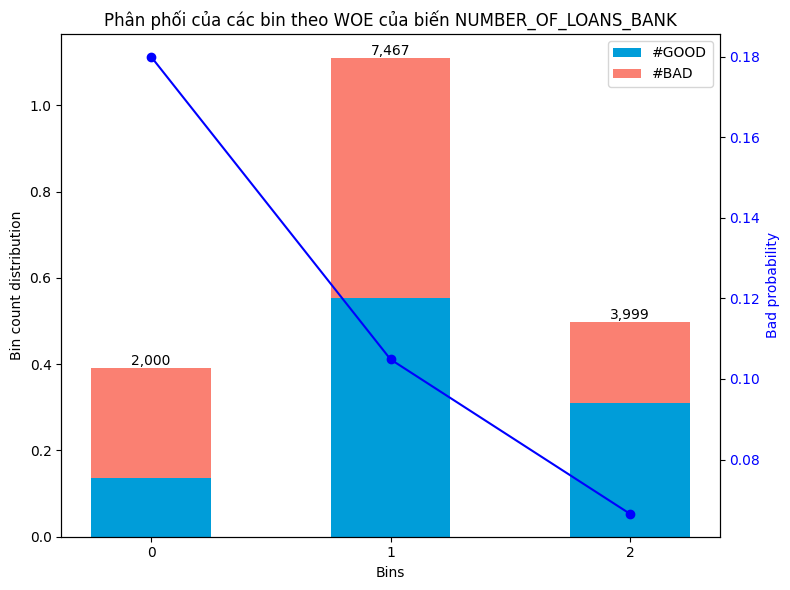

In [358]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_summary is your dataframe
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot for distribution of good and bad
bars_good = ax1.bar(df_summary.index.astype(str), df_summary['Distribution Good'], label='#GOOD', color="#009dd9", width=0.5)
bars_bad = ax1.bar(df_summary.index.astype(str), df_summary['Distribution Bad'], bottom=df_summary['Distribution Good'], label='#BAD', color='salmon', width=0.5)

ax1.set_ylabel('Bin count distribution')
ax1.set_xlabel('Bins')
ax1.legend()

# Add the secondary axis for bad probability
ax2 = ax1.twinx()
ax2.plot(df_summary.index.astype(str), df_summary['Bad Rate'], color='blue', marker='o', label='Bad Rate')
ax2.set_ylabel('Bad probability', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Annotate the bars with No_Obs
for i, bar in enumerate(bars_good):
    ax1.text(bar.get_x() + bar.get_width() / 2., 
             bar.get_height() + bars_bad[i].get_height(), 
             f"{df_summary['No_Obs'].iloc[i]:,}", ha='center', va='bottom')

# Uncomment this section if you want to annotate bad rate on the line
# for i, (x, y) in enumerate(zip(df_summary.index.astype(str), df_summary['Bad Rate'])):
#     ax2.annotate(f"{y*100:.1f}%", (x, y), textcoords="offset points", xytext=(0, -30), ha='center', color='black')

plt.title('Phân phối của các bin theo WOE của biến NUMBER_OF_LOANS_BANK')
plt.tight_layout()
plt.show()


In [359]:
def _WOE(df, colname, n_bins = None, min_obs = 100, qcut = None):
  # Thống kê bins và lấy ra thres hold ban đầu
  df_summary, thres = _bin_table(df, colname, n_bins = n_bins, qcut = qcut)
  # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0
  df_summary['#BAD'] = df_summary['#BAD'].replace({0:1})
  
  if qcut is not None:
    # Lọc bỏ threshold để tạo thành threshold mới mà thỏa mãn số lượng quan sát >= min_obs
    exclude_ind = np.where(df_summary['No_Obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Tính toán lại bảng summary
      df_summary, thres = _bin_table(df, colname, qcut=new_thres)
  
  new_thres = thres
  df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
  df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
  df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
  df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
  df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
  df_summary['COLUMN'] = colname
  IV = df_summary['IV'].sum()
  print('Information Value of {} column: {}'.format(colname, IV))
  return df_summary, IV, new_thres

df_summary, IV, thres = _WOE(df, 'NUMBER_OF_LOANS_BANK', n_bins = 3, min_obs= 100)
df_summary

Information Value of NUMBER_OF_LOANS_BANK column: 0.5366198018526882


,Thres,No_Obs,#GOOD,#BAD,GOOD/BAD,%BAD,%GOOD,WOE,IV,COLUMN
bins,,,,,,,,,,
"(-10.0, 3.84]",3.839833e+00,8534,5939,2595,2.288632,0.712130,0.363108,-0.673559,0.235086,NUMBER_OF_LOANS_BANK
"(3.84, 4.0]",4.000000e+00,7467,6684,783,8.536398,0.214874,0.408657,0.642826,0.124569,NUMBER_OF_LOANS_BANK
"(4.0, 1900000.0]",1.900000e+06,3999,3733,266,14.033835,0.072997,0.228234,1.139958,0.176964,NUMBER_OF_LOANS_BANK


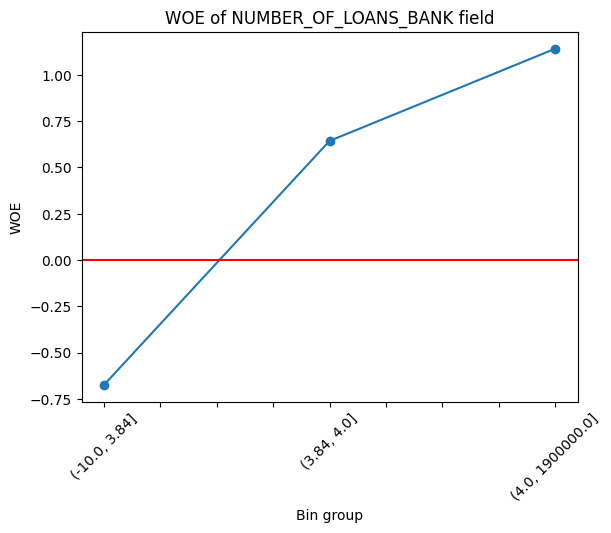

In [360]:
def _plot(df_summary):
  colname = list(df_summary['COLUMN'].unique())[0]
  df_summary['WOE'].plot(linestyle='-', marker='o')
  plt.title('WOE of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('WOE')
  plt.xlabel('Bin group')

_plot(df_summary)

In [361]:
df.columns.drop('customer_id')

Index(['label', 'SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT',
       'LONG_TERM_COUNT_NON_BANK', 'NUMBER_OF_LOANS_BANK',
       'NUMBER_OF_LOANS_NON_BANK', 'NUMBER_OF_CREDIT_CARDS',
       'NUMBER_OF_CREDIT_CARDS_NON_BANK', 'NUM_NEW_LOAN_TAKEN_3M',
       'OUTSTANDING_BAL_LOAN_CURRENT', 'OUTSTANDING_BAL_LOAN_3M_6M',
       'OUTSTANDING_BAL_CC_3M_6M', 'OUTSTANDING_BAL_ALL_9M_12M',
       'INCREASING_BAL_3M_LOAN', 'INCREASING_BAL_6M_LOAN',
       'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT', 'ENQUIRIES_3M',
       'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_3M',
       'ENQUIRIES_FROM_NON_BANK_FOR_CC_3M', 'ENQUIRIES_3M_6M',
       'ENQUIRIES_6M_9M', 'ENQUIRIES_9M_12M', 'ENQUIRIES_FROM_BANK_6M_9M',
       'Diff_in_term_count', 'RATIO_SHORT', 'RATIO_SHORT_BANK',
       'RATIO_SHORT_NON_BANK', 'RATIO_MID_NON_BANK', 'RATIO_RELATIONSHIP',
       'RATIO_RELATIONSHIP_BANK', 'RATIO_RELATIONSHIP_NON_BANK'],
      dtype='object')

In [362]:
nbins = {
    'OUTSTANDING_BAL_LOAN_CURRENT': 10,

    'OUTSTANDING_BAL_LOAN_3M_6M': 10,
   
    'OUTSTANDING_BAL_CC_3M_6M': 3,
    
    'OUTSTANDING_BAL_ALL_9M_12M': 3,
  
    'SHORT_TERM_COUNT': 4,
    'MID_TERM_COUNT': 2,
    'LONG_TERM_COUNT': 1,

    'LONG_TERM_COUNT_NON_BANK': 1,
    'NUMBER_OF_LOANS_BANK': 3,
    'NUMBER_OF_LOANS_NON_BANK': 3,
    'NUMBER_OF_CREDIT_CARDS': 3,
    'NUMBER_OF_CREDIT_CARDS_NON_BANK': 1,
  
    'NUM_NEW_LOAN_TAKEN_3M': 2,


    'INCREASING_BAL_3M_LOAN': 1,
    'INCREASING_BAL_6M_LOAN': 1,

    'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT': 1,
    'ENQUIRIES_3M': 2,

    'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_3M': 2,
    'ENQUIRIES_FROM_NON_BANK_FOR_CC_3M': 1,
 
    'ENQUIRIES_3M_6M': 1,
    'ENQUIRIES_6M_9M': 1,
    'ENQUIRIES_9M_12M': 1,
 
    'ENQUIRIES_FROM_BANK_6M_9M': 2,
  
    'Diff_in_term_count': 3,
   
    'RATIO_SHORT': 4,
    
    'RATIO_SHORT_BANK': 2,
    'RATIO_SHORT_NON_BANK': 3,

    'RATIO_MID_NON_BANK': 4,
    'RATIO_RELATIONSHIP': 6,
    'RATIO_RELATIONSHIP_BANK': 4,
    'RATIO_RELATIONSHIP_NON_BANK': 3,
}


In [363]:
WOE_dict=dict()
for (col, bins) in nbins.items():
  df_summary, IV, thres = _WOE(df, colname=col, n_bins=bins)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of OUTSTANDING_BAL_LOAN_CURRENT column: 0.9326729210619611
Information Value of OUTSTANDING_BAL_LOAN_3M_6M column: 1.0952793981835063
Information Value of OUTSTANDING_BAL_CC_3M_6M column: 0.24824228006248408
Information Value of OUTSTANDING_BAL_ALL_9M_12M column: 0.1053434037827916
Information Value of SHORT_TERM_COUNT column: 0.43631707628593286
Information Value of MID_TERM_COUNT column: 0.14946258898119874
Information Value of LONG_TERM_COUNT column: 0.0
Information Value of LONG_TERM_COUNT_NON_BANK column: 0.0
Information Value of NUMBER_OF_LOANS_BANK column: 0.5366198018526882
Information Value of NUMBER_OF_LOANS_NON_BANK column: 0.20754789731956452
Information Value of NUMBER_OF_CREDIT_CARDS column: 0.25043676338264614
Information Value of NUMBER_OF_CREDIT_CARDS_NON_BANK column: 0.0
Information Value of NUM_NEW_LOAN_TAKEN_3M column: 0.08129308549233696
Information Value of INCREASING_BAL_3M_LOAN column: 0.0
Information Value of INCREASING_BAL_6M_LOAN column: 0.0

In [364]:
columns = []
IVs = []
# cols = df.columns[df.columns.str.startswith('OUTS') | df.columns.str.startswith('INCR')]
# Loop through all columns except 'label', 'customer_id', and those in 'cols'
for col in df.columns.drop(['label', 'customer_id']):
    columns.append(col)
    IVs.append(WOE_dict[col]['IV'])
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})

def _rank_IV(iv):
  if iv <= 0.02:
    return 'Useless'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'suspicious'

df_WOE['rank']=df_WOE['IV'].apply(lambda x: _rank_IV(x))
df_WOE.sort_values('IV', ascending=False)

,column,IV,rank
10,OUTSTANDING_BAL_LOAN_3M_6M,1.095279,suspicious
9,OUTSTANDING_BAL_LOAN_CURRENT,0.932673,suspicious
4,NUMBER_OF_LOANS_BANK,0.536620,suspicious
0,SHORT_TERM_COUNT,0.436317,Strong
28,RATIO_RELATIONSHIP,0.354681,Strong
29,RATIO_RELATIONSHIP_BANK,0.340332,Strong
6,NUMBER_OF_CREDIT_CARDS,0.250437,Medium
11,OUTSTANDING_BAL_CC_3M_6M,0.248242,Medium
5,NUMBER_OF_LOANS_NON_BANK,0.207548,Medium
23,Diff_in_term_count,0.179163,Medium


In [365]:
# Fix 1: Assuming 'column' refers to column names in df_WOE
drop_cols = df_WOE[df_WOE['rank'] == 'Useless']['column'].to_list()

# Fix 2: Adding column names to the list properly
# drop_cols += ["Diff_in_num_loan", 'RATIO_LONG_NON_BANK', 'RATIO_MID', 'RATIO_MID_BANK']

# Drop the columns from df_WOE
# df_WOE.drop(columns=drop_cols, inplace=True)
for col in drop_cols:
    WOE_dict.pop(col, None)  

In [366]:
WOE_dict.keys()

dict_keys(['OUTSTANDING_BAL_LOAN_CURRENT', 'OUTSTANDING_BAL_LOAN_3M_6M', 'OUTSTANDING_BAL_CC_3M_6M', 'OUTSTANDING_BAL_ALL_9M_12M', 'SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK', 'NUMBER_OF_CREDIT_CARDS', 'NUM_NEW_LOAN_TAKEN_3M', 'ENQUIRIES_FROM_BANK_6M_9M', 'Diff_in_term_count', 'RATIO_SHORT', 'RATIO_SHORT_NON_BANK', 'RATIO_MID_NON_BANK', 'RATIO_RELATIONSHIP', 'RATIO_RELATIONSHIP_BANK', 'RATIO_RELATIONSHIP_NON_BANK'])

In [367]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['WOE'].index)
    woe = list(WOE_dict[col]['table']['WOE'])
    d = dict(zip(key, woe))
    col_woe = col+'_WOE'
    df[col_woe] = df[col].map(d)
  except:
    print(col)

**We will drop some low (< 0.02) IV columns**

## Train-Validation-Test Split for 6 Models after Feature Engineering

In [368]:
# Assuming your data is stored in X and y
X = df.filter(like='_WOE', axis = 1)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, df["label"], test_size=0.4, random_state=42)
# Split the validation and test sets into equal proportions
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 12000
Validation set size: 4000
Test set size: 4000


In [369]:
print("Train set size:", y_train.value_counts() / len(y_train))
print("Validation set size:", y_val.value_counts() / len(y_val))
print("Test set size:", y_test.value_counts() / len(y_test))

Train set size: label
0    0.815333
1    0.184667
Name: count, dtype: float64
Validation set size: label
0    0.8225
1    0.1775
Name: count, dtype: float64
Test set size: label
0    0.8205
1    0.1795
Name: count, dtype: float64


### Standard scaler

In [370]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Model Selection

## Model 1: Logistic Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 87.375%
AUC Score: 0.7819217432253094

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      3290
           1       0.80      0.38      0.52       710

    accuracy                           0.87      4000
   macro avg       0.84      0.68      0.72      4000
weighted avg       0.87      0.87      0.85      4000


Gini Index: {:.2f} 0.5638434864506188


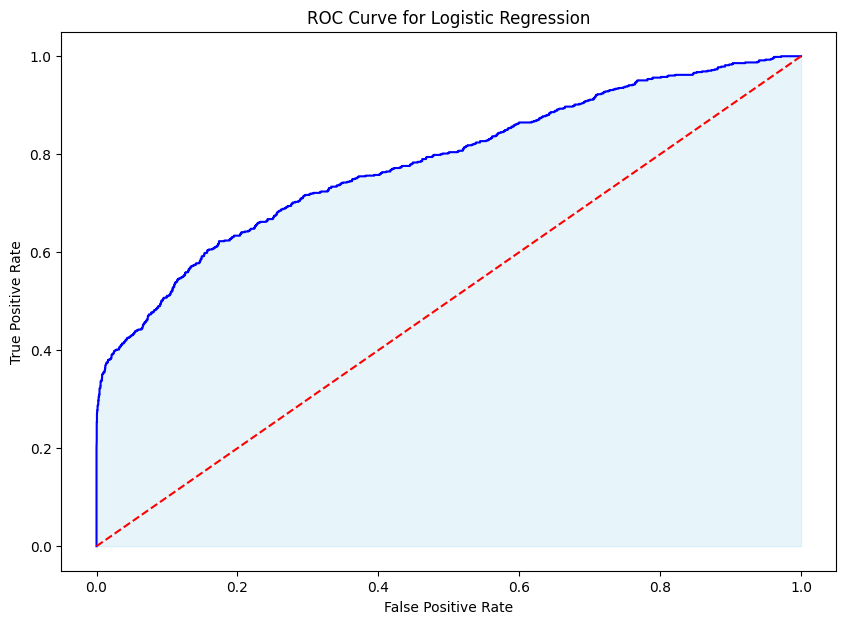

In [371]:
param_grid = {
    'solver': ['lbfgs'],  # Different solvers to try
    'C': [ 0.01],  # Regularization strength
    'penalty': ['l2'],  # Penalty type (l1 can only be used with some solvers)
    'max_iter': [5000, 4000]  # Iterations for convergence
    
}

# Instantiate the logistic regression model
lr = LogisticRegression(fit_intercept=True)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lr,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='roc_auc',  # AUC score for evaluation
                           verbose=1,
                           n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_lr_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predictions using the best model
y_pred = best_lr_model.predict(X_val)
y_pred_proba = best_lr_model.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")
evaluate(y_val,y_pred,y_pred_proba, "Logistic Regression")

In [372]:
import numpy as np

def _CreditScore(beta, alpha, woe, n = 134, odds = 1/4, pdo = 50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

_CreditScore(beta = 0.5, alpha = -1, woe = 0.15, n = 134)

10.095667955240717

In [373]:
# Create a list of columns to drop
columns_to_drop = ['label', 'customer_id'] + drop_cols

# Drop the unwanted columns and create the dictionary
betas_dict = dict(zip(df.columns.drop(columns_to_drop), best_lr_model.coef_[0]))
alpha = best_lr_model.intercept_[0]
df.columns.drop(columns_to_drop)

Index(['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'NUMBER_OF_LOANS_BANK',
       'NUMBER_OF_LOANS_NON_BANK', 'NUMBER_OF_CREDIT_CARDS',
       'NUM_NEW_LOAN_TAKEN_3M', 'OUTSTANDING_BAL_LOAN_CURRENT',
       'OUTSTANDING_BAL_LOAN_3M_6M', 'OUTSTANDING_BAL_CC_3M_6M',
       'OUTSTANDING_BAL_ALL_9M_12M', 'ENQUIRIES_FROM_BANK_6M_9M',
       'Diff_in_term_count', 'RATIO_SHORT', 'RATIO_SHORT_NON_BANK',
       'RATIO_MID_NON_BANK', 'RATIO_RELATIONSHIP', 'RATIO_RELATIONSHIP_BANK',
       'RATIO_RELATIONSHIP_NON_BANK', 'OUTSTANDING_BAL_LOAN_CURRENT_WOE',
       'OUTSTANDING_BAL_LOAN_3M_6M_WOE', 'OUTSTANDING_BAL_CC_3M_6M_WOE',
       'OUTSTANDING_BAL_ALL_9M_12M_WOE', 'SHORT_TERM_COUNT_WOE',
       'MID_TERM_COUNT_WOE', 'NUMBER_OF_LOANS_BANK_WOE',
       'NUMBER_OF_LOANS_NON_BANK_WOE', 'NUMBER_OF_CREDIT_CARDS_WOE',
       'NUM_NEW_LOAN_TAKEN_3M_WOE', 'ENQUIRIES_FROM_BANK_6M_9M_WOE',
       'Diff_in_term_count_WOE', 'RATIO_SHORT_WOE', 'RATIO_SHORT_NON_BANK_WOE',
       'RATIO_MID_NON_BANK_WOE', 'RATIO_RE

In [374]:
columns_to_drop.remove('label')
columns_to_drop.remove('customer_id')

In [375]:
for i in columns_to_drop:
    columns.remove(i)

In [376]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
    for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
        cols.append(col)
        # Add feature
        feature = str(feature)
        features.append(feature)
        # Add woe
        woe = woe.values[0]
        woes.append(woe)
        # Add beta (adjusted to match the keys in betas_dict)
        beta = betas_dict[col]
        betas.append(beta)
        # Add score
        score = _CreditScore(beta=beta, alpha=alpha, woe=woe, n=134)
        scores.append(score)

# Create DataFrame with the collected data
df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas': betas, 'Scores': scores})
df_WOE.head()


,Columns,Features,WOE,Betas,Scores
0,SHORT_TERM_COUNT,"(-10.0, 4.0]",-0.579994,-0.369097,19.657342
1,SHORT_TERM_COUNT,"(4.0, 6.041]",-0.028598,-0.369097,4.976560
2,SHORT_TERM_COUNT,"(6.041, 7.0]",0.672699,-0.369097,-13.695290
3,SHORT_TERM_COUNT,"(7.0, 1900000.0]",1.094324,-0.369097,-24.920958
4,MID_TERM_COUNT,"(-10.0, 3.317]",-0.289037,-0.525720,15.176205


In [410]:
df_WOE.to_csv('WOE.csv', index=False)

In [377]:
# Giả sử một hồ sơ ngẫu nhiên có các thông số như sau
test_obs = df[columns].iloc[0:2, :]
test_obs

,SHORT_TERM_COUNT,MID_TERM_COUNT,NUMBER_OF_LOANS_BANK,NUMBER_OF_LOANS_NON_BANK,NUMBER_OF_CREDIT_CARDS,NUM_NEW_LOAN_TAKEN_3M,OUTSTANDING_BAL_LOAN_CURRENT,OUTSTANDING_BAL_LOAN_3M_6M,OUTSTANDING_BAL_CC_3M_6M,OUTSTANDING_BAL_ALL_9M_12M,ENQUIRIES_FROM_BANK_6M_9M,Diff_in_term_count,RATIO_SHORT,RATIO_SHORT_NON_BANK,RATIO_MID_NON_BANK,RATIO_RELATIONSHIP,RATIO_RELATIONSHIP_BANK,RATIO_RELATIONSHIP_NON_BANK
0,1.0,1.0,1.0,1.0,1.0,1.0,1000000.0,1.000000e+06,1.000000e+06,1.000000e+06,1.524688,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.00
1,10.0,1.0,7.0,4.0,10.0,7.0,1000250.0,1.000011e+06,1.000014e+06,1.000011e+06,2.000000,0.666667,1.188307,1.0,0.682708,2.257783,1.857143,1.75


In [379]:
def _search_score(obs, col):
  feature = [str(inter) for inter in list(WOE_dict[col]['table'].index) if obs[col].values[0] in inter][0]
  score = df_WOE[(df_WOE['Columns'] == col) & (df_WOE['Features'] == feature)]['Scores'].values[0]
  return score

# Tính điểm cho trường 'LOAN' của bộ hồ sơ test
score = _search_score(test_obs, 'NUMBER_OF_LOANS_BANK')
score

6.404716963607479

In [380]:
def _total_score(obs, columns = columns):
  scores = dict()
  for col in columns:
    scores[col] = _search_score(obs, col)
  total_score = sum(scores.values())
  return scores, total_score

scores, total_score = _total_score(test_obs)
print('score for each fields: \n', scores)
print('final total score: ', total_score)

score for each fields: 
 {'SHORT_TERM_COUNT': 19.657341532781363, 'MID_TERM_COUNT': 15.176205398863386, 'NUMBER_OF_LOANS_BANK': 6.404716963607479, 'NUMBER_OF_LOANS_NON_BANK': 6.3750104946502795, 'NUMBER_OF_CREDIT_CARDS': 5.592271192573178, 'NUM_NEW_LOAN_TAKEN_3M': 3.6980968126888447, 'OUTSTANDING_BAL_LOAN_CURRENT': 62.123834216627415, 'OUTSTANDING_BAL_LOAN_3M_6M': 10.733644483175734, 'OUTSTANDING_BAL_CC_3M_6M': 10.994230174962743, 'OUTSTANDING_BAL_ALL_9M_12M': 2.8331306055908443, 'ENQUIRIES_FROM_BANK_6M_9M': 3.4688870281769626, 'Diff_in_term_count': 4.339822112365512, 'RATIO_SHORT': 4.152336885354124, 'RATIO_SHORT_NON_BANK': 4.671331476293731, 'RATIO_MID_NON_BANK': 8.836267020713327, 'RATIO_RELATIONSHIP': 8.896134035440122, 'RATIO_RELATIONSHIP_BANK': 15.733386791554766, 'RATIO_RELATIONSHIP_NON_BANK': 3.893674452905831}
final total score:  197.58032167832567


In [381]:
total_scores = []
for i in np.arange(df[columns].shape[0]):
  obs = df[columns].iloc[i:(i+1), :]
  _, score = _total_score(obs)
  total_scores.append(score)
df['Score'] = total_scores

In [383]:
print(df["Score"].max())
print(df["Score"].min())
print(df["Score"].mean())
print(df["Score"].std())
print(df.Score.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]))
df.Score.to_csv("Score.csv")

209.3510636284436
-54.68179072834977
58.08311757382897
54.54723053975249
0.25     20.428425
0.50     49.259172
0.75     80.213701
0.90    142.955301
0.95    183.843365
0.99    199.158790
1.00    209.351064
Name: Score, dtype: float64


## Model 3: XGBoost

Cross-Validation ROC-AUC Scores: [0.78596484 0.79131693 0.78084575 0.76268786 0.79942865]
Average Cross-Validation ROC-AUC Score: 0.7840488019410415
Test Set Accuracy: 87.225%
Test Set AUC Score: 0.767116743011259

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      3290
           1       0.79      0.38      0.52       710

    accuracy                           0.87      4000
   macro avg       0.83      0.68      0.72      4000
weighted avg       0.86      0.87      0.85      4000


Gini Index: {:.2f} 0.534233486022518


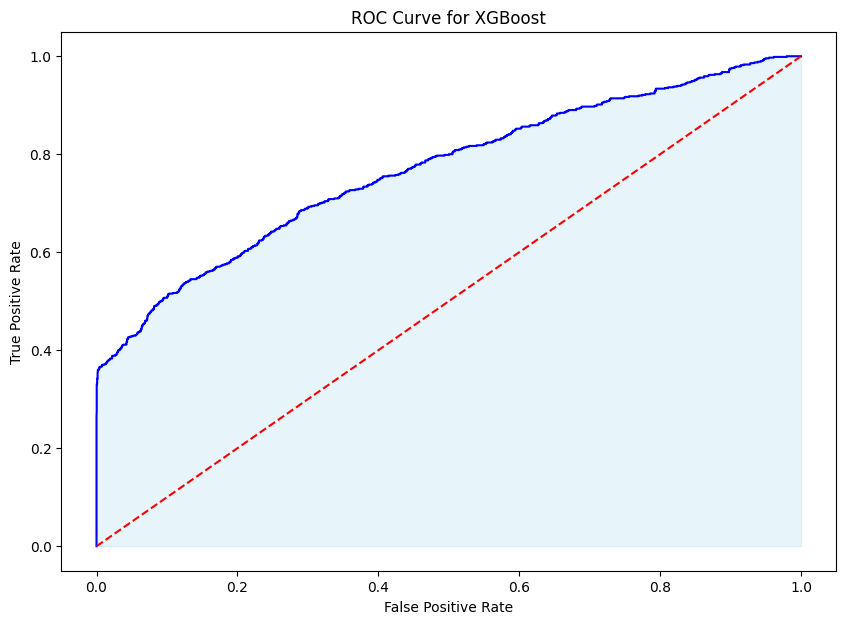

In [403]:
params = {
#     'subsample': 0.7222222222222222, 'reg_lambda': 0.6666666666666666, 'reg_alpha': 0.5555555555555556, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.019999999999999997, 'gamma': 0.05555555555555555, 'colsample_bytree': 0.5
          }

# Initialize XGBoost Classifier with selected parameters
xgb_model = xgb.XGBClassifier(**params)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
xgb_model.fit(X_train, y_train)

# Predictions on the test set
xgb_y_pred = xgb_model.predict(X_val)
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
xgb_accuracy = accuracy_score(y_val, xgb_y_pred)
xgb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {xgb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {xgb_auc_score}")

# # Display feature importance
# feature_importance = xgb_model.feature_importances_
# sorted_idx = np.argsort(feature_importance)[::-1]

# print("\nTop 10 Feature Importance:")
# for i in range(10):
#     print(f"{train_balanced[sorted_idx[i]]}: {feature_importance[sorted_idx[i]]}")
evaluate(y_val,xgb_y_pred,y_pred_proba, "XGBoost")

# Model - LightGBM

[LightGBM] [Info] Number of positive: 1773, number of negative: 7827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184688 -> initscore=-1.484906
[LightGBM] [Info] Start training from score -1.484906
[LightGBM] [Info] Number of positive: 1773, number of negative: 7827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 18
[LightGBM] [Info] [binary:Bo

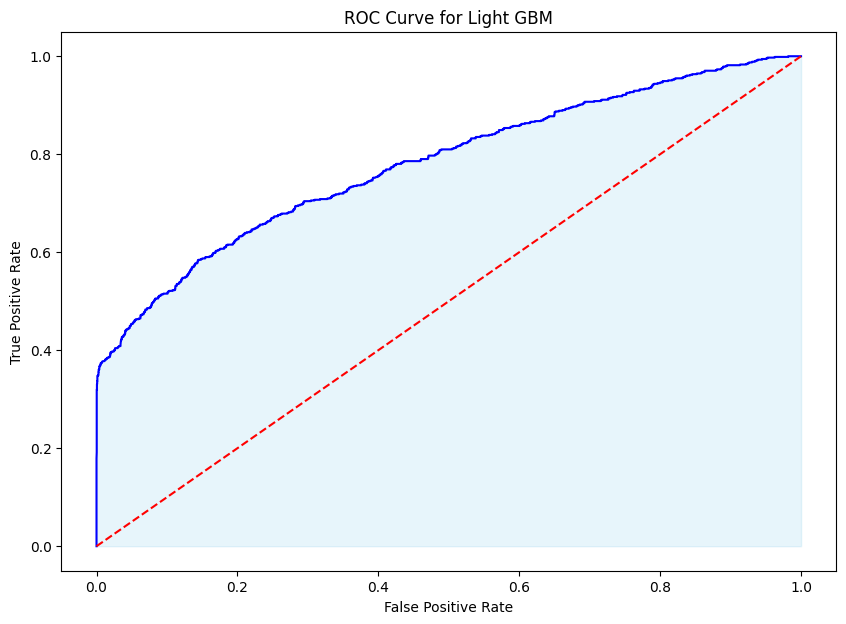

In [404]:
params = {
#     'bagging_fraction': 0.7559247410755839, 'bagging_freq': 2, 'feature_fraction': 0.6785986360743963, 'lambda_l1': 0.003084514923441306, 'learning_rate': 0.041501214401114275, 'max_depth': 15, 'min_data_in_leaf': 22, 'n_estimators': 136, 'num_leaves': 31
          }

# Initialize LightGBM Classifier with selected parameters
lgb_model = lgb.LGBMClassifier(**params)

# Perform cross-validation
cv_scores = cross_val_score(lgb_model,X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
lgb_model.fit(X_train, y_train)

# Predictions on the test set
lgb_y_pred = lgb_model.predict(X_val)
y_pred_proba = lgb_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
lgb_accuracy = accuracy_score(y_val, lgb_y_pred)
lgb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {lgb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {lgb_auc_score}")
evaluate(y_val,lgb_y_pred,y_pred_proba, "Light GBM")

In [405]:
# lgb.plot_importance(lgb_model, importance_type="gain", max_num_features=15 ,figsize=(20,15), title="LightGBM Feature Importance (Gain)", grid=False, color = "#009dd9")
# plt.show()


## Model 6: Random Forest

Cross-Validation ROC-AUC Scores: [0.78773425 0.78146746 0.76303217 0.77812068 0.79180657]
Average Cross-Validation ROC-AUC Score: 0.7804322266567192
Test Set Accuracy: 87.225%
Test Set AUC Score: 0.7416000256860311

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93      3290
           1       0.77      0.40      0.53       710

    accuracy                           0.87      4000
   macro avg       0.83      0.69      0.73      4000
weighted avg       0.86      0.87      0.86      4000


Gini Index: {:.2f} 0.48320005137206223


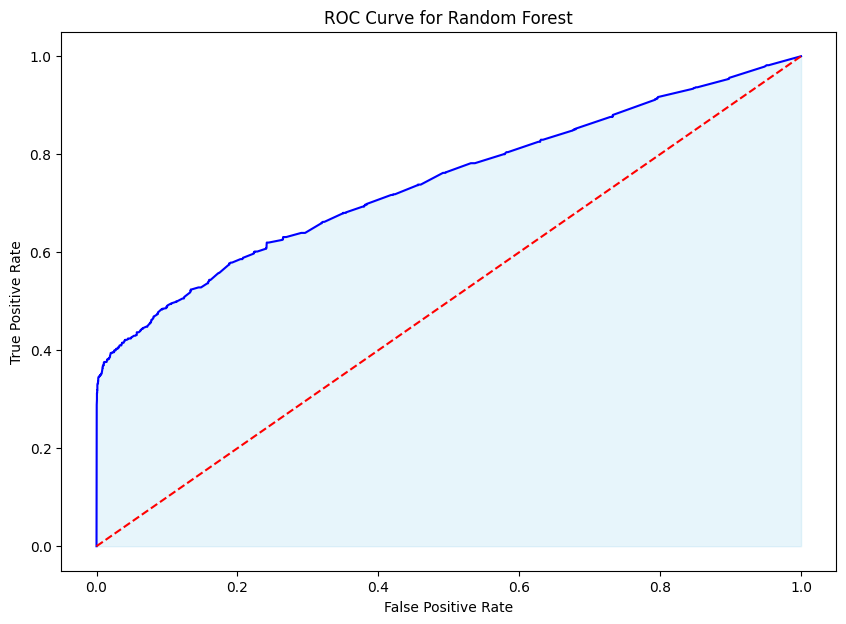

In [406]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
#     n_estimators=300,
#     n_jobs=-1,
#     max_depth=16,
#     min_samples_split=10,
#     min_samples_leaf=7,
#     max_features='sqrt',
#     bootstrap=True,
#     criterion='gini',
#     random_state=42,
    
)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Predictions on the test set
rf_y_pred = rf_model.predict(X_val)
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
rf_accuracy = accuracy_score(y_val, rf_y_pred)
rf_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {rf_accuracy * 100.0}%")
print(f"Test Set AUC Score: {rf_auc_score}")
evaluate(y_val,rf_y_pred,y_pred_proba, "Random Forest")


Cross-Validation ROC-AUC Scores: [0.76675729 0.7445911  0.74337304 0.74463032 0.76251981]
Average Cross-Validation ROC-AUC Score: 0.7523743112436372
Test Set Accuracy: 86.35000000000001%
Test Set AUC Score: 0.7343668393338756

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      3290
           1       0.71      0.39      0.51       710

    accuracy                           0.86      4000
   macro avg       0.79      0.68      0.71      4000
weighted avg       0.85      0.86      0.85      4000


Gini Index: {:.2f} 0.4687336786677512


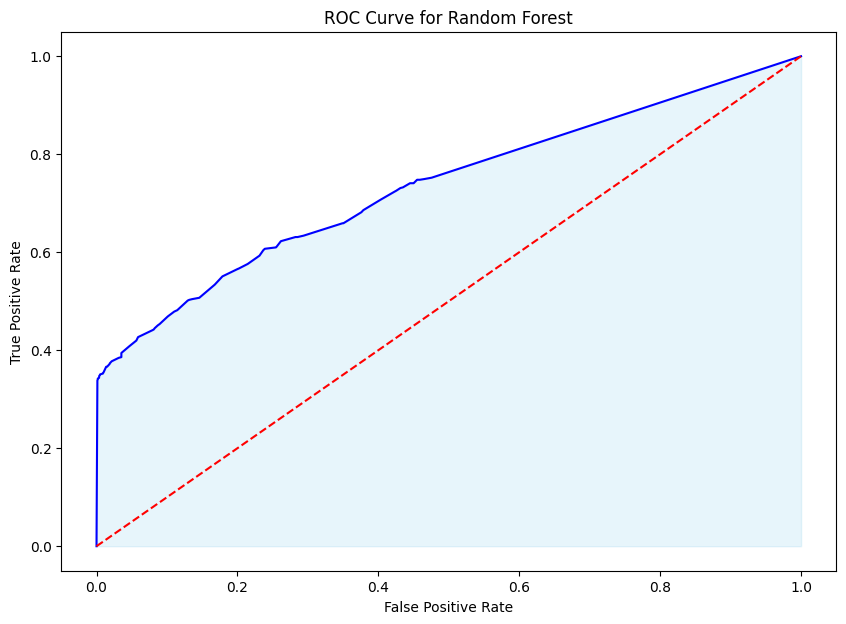

In [407]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score

# Define the Decision Tree Classifier with similar hyperparameters (adjust as needed)
dt_model = DecisionTreeClassifier(
    max_depth=16,
    min_samples_split=10,
    min_samples_leaf=7,
    random_state=42
)

# Perform cross-validation with ROC-AUC as the scoring metric
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the decision tree model on the entire training set
dt_model.fit(X_train, y_train)

# Make predictions on the test set
dt_y_pred = dt_model.predict(X_val)
dt_pred_proba = dt_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
dt_accuracy = accuracy_score(y_val, dt_y_pred)
dt_auc_score = roc_auc_score(y_val, dt_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {dt_accuracy * 100.0}%")
print(f"Test Set AUC Score: {dt_auc_score}")

evaluate(y_val,dt_y_pred,dt_pred_proba, "Random Forest")


# Final Results

In [408]:
final_results = pd.DataFrame(results)
final_results

,Model,GINI,ROC AUC Score
0,XGBoost,0.534233,0.767117
1,Light GBM,0.559580,0.779790
2,Random Forest,0.483200,0.741600
3,Random Forest,0.468734,0.734367


# Fit Best Model on Test Set: Gradient Boosting

Cross-Validation ROC-AUC Scores: [0.76675729 0.7445911  0.74337304 0.74463032 0.76251981]
Average Cross-Validation ROC-AUC Score: 0.7523743112436372
Test Set Accuracy: 88.1%
Test Set AUC Score: 0.791920859792334

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      3282
           1       0.85      0.41      0.55       718

    accuracy                           0.88      4000
   macro avg       0.87      0.70      0.74      4000
weighted avg       0.88      0.88      0.86      4000


Gini Index: {:.2f} 0.5838417195846679


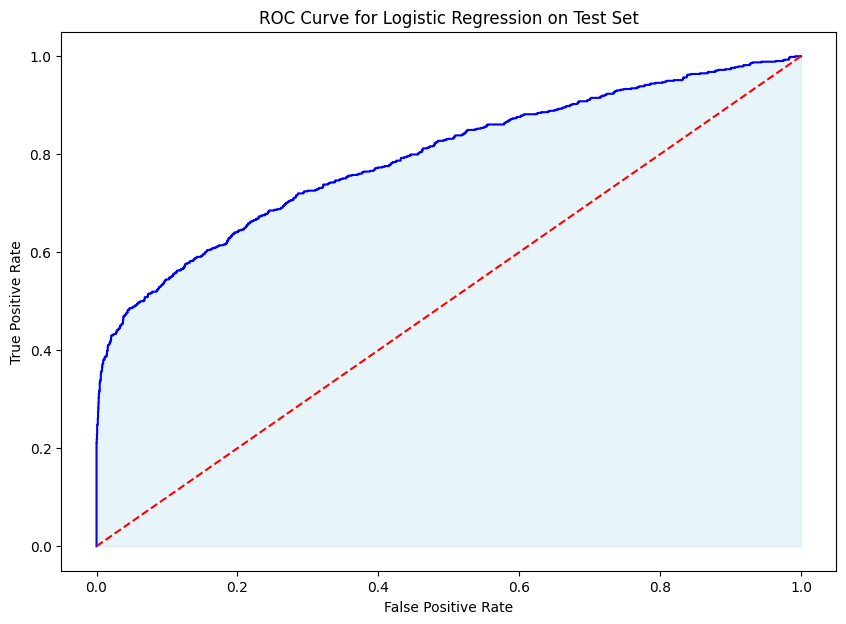

In [400]:

# Predictions on the test set
lr_y_pred = best_lr_model.predict(X_test)
y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC Score on the test set
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {lr_accuracy * 100.0}%")
print(f"Test Set AUC Score: {lr_auc_score}")
evaluate(y_test,lr_y_pred,y_pred_proba, "Logistic Regression on Test Set")

In [402]:
results.clear()